# Run inference on a Sentinel-2 image from the Google Earth Engine

* **Last Modified**: 11-07-2024
* **Author**: Gonzalo Mateo-García
---
<h1> <img src="./logo.webp" alt="Logo" width='5%'> CloudSEN12</h1>

This notebook shows how to run the CloudSEN12 model over an image downloaded from the Google Earth Engine. Hence to run this notebook you a Google Earth Engine account. 

We will run the model with all bands proposed in:

> Aybar, C., Ysuhuaylas, L., Loja, J., Gonzales, K., Herrera, F., Bautista, L., Yali, R., Flores, A., Diaz, L., Cuenca, N., Espinoza, W., Prudencio, F., Llactayo, V., Montero, D., Sudmanns, M., Tiede, D., Mateo-García, G., & Gómez-Chova, L. (2022). **CloudSEN12, a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2**. Scientific Data, 9(1), Article 1. https://doi.org/10.1038/s41597-022-01878-2
>
> 

In [1]:
from cloudsen12_models import cloudsen12
import ee
import matplotlib.pyplot as plt
from georeader import plot
from shapely.geometry import box
from georeader.readers import ee_image

/home/gonzalo/mambaforge/envs/marsmlpy312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ee.Initialize(project="marsml")

In [3]:
collection_name = "COPERNICUS/S2_HARMONIZED"
tile = "S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("PRODUCT_ID", tile)).first()
info_img = image.getInfo()
info_img

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32640',
   'crs_transform': [60, 0, 300000, 0, -60, 2800020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32640',
   'crs_transform': [10, 0, 300000, 0, -10, 2800020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [4]:
%%time

# projgee = image.select("B2").projection().getInfo()

aoi = box(55.325, 25.225, 55.415, 25.28)

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
# img_local = ee_image.export_image_fast(image=image, geometry=aoi)
img_local = ee_image.export_image_getpixels(asset_id=info_img['id'],
                                            proj=projgee,
                                            bands_gee=bands,
                                            geometry=aoi)
img_local

CPU times: user 128 ms, sys: 46.3 ms, total: 175 ms
Wall time: 3.83 s


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


 
         Transform: | 10.00, 0.00, 331260.00|
| 0.00,-10.00, 2797010.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 622, 916)
         Resolution: (10.0, 10.0)
         Bounds: (331260.0, 2790790.0, 340420.0, 2797010.0)
         CRS: EPSG:32640
         fill_value_default: 0.0
        

<Axes: >

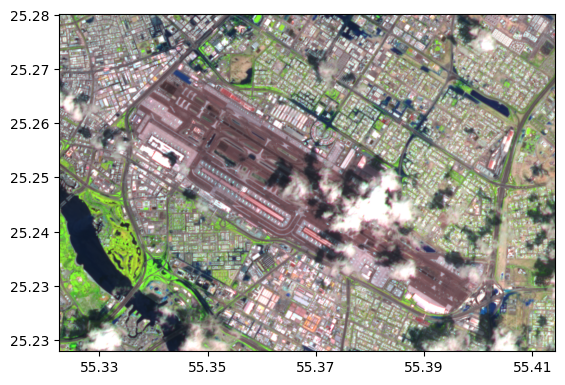

In [5]:
swirnirred = (img_local.isel({"band": [bands.index(b) for b in ["B11","B8","B4"]]}) / 4_500.).clip(0,1)

plot.show(swirnirred)

In [6]:
model = cloudsen12.load_model_by_name(name="cloudsen12", weights_folder="cloudsen12_models")

In [9]:
cloudmask = model.predict(img_local/10_000)

<Axes: >

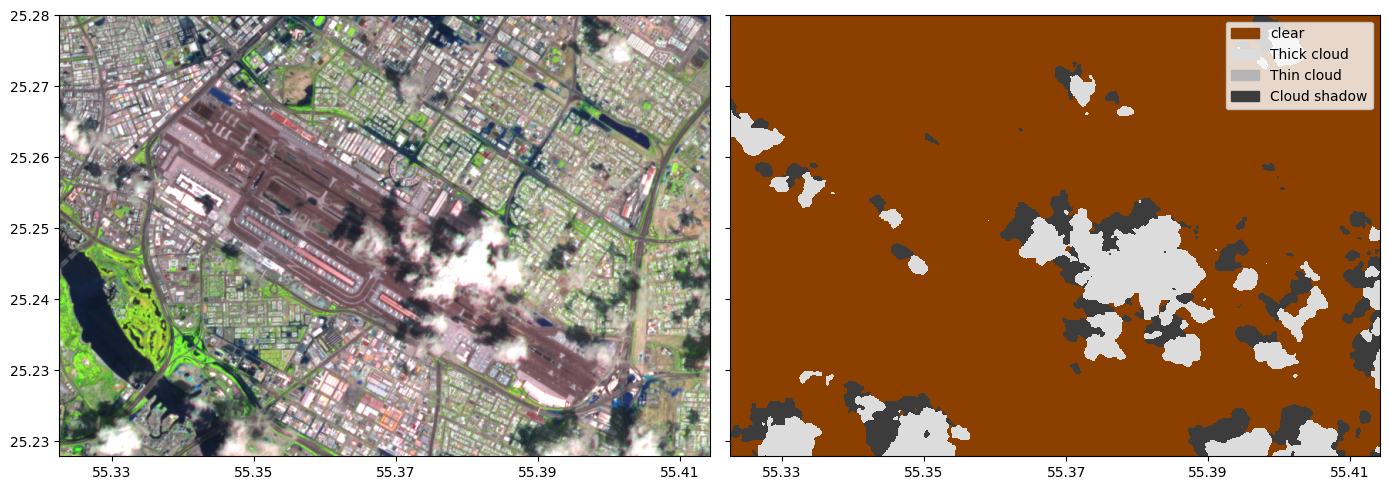

In [10]:
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True, tight_layout=True)

plot.show(swirnirred,ax=ax[0])
cloudsen12.plot_cloudSEN12mask(cloudmask,ax=ax[1])

## Licence
The `cloudsen12_models` package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

The *CloudSEN12* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

This notebook is released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt).

 If you find this work useful please cite:
```
@article{aybar_cloudsen12_2022,
	title = {{CloudSEN12}, a global dataset for semantic understanding of cloud and cloud shadow in {Sentinel}-2},
	volume = {9},
	issn = {2052-4463},
	url = {https://www.nature.com/articles/s41597-022-01878-2},
	doi = {10.1038/s41597-022-01878-2},
	number = {1},
	urldate = {2023-01-02},
	journal = {Scientific Data},
	author = {Aybar, Cesar and Ysuhuaylas, Luis and Loja, Jhomira and Gonzales, Karen and Herrera, Fernando and Bautista, Lesly and Yali, Roy and Flores, Angie and Diaz, Lissette and Cuenca, Nicole and Espinoza, Wendy and Prudencio, Fernando and Llactayo, Valeria and Montero, David and Sudmanns, Martin and Tiede, Dirk and Mateo-García, Gonzalo and Gómez-Chova, Luis},
	month = dec,
	year = {2022},
	pages = {782},
}
```